## Basics

In [1]:
from primitives import Parameters
p = Parameters()
import pickle
import matplotlib.pyplot as plt
import numpy as np
from plots import Plots
plts=Plots(p)
cc_J,cc_W,cc_Wstar,cc_Jpi,cc_pc,mwc_J,mwc_W,mwc_Wstar,mwc_pc,mwc_n1,mwc_s_J,mwc_s_W,mwc_s_Wstar,mwc_s_sep,mwc_s_dir_J,mwc_s_dir_W,mwc_s_dir_Wstar,mwc_s_dir_sep=None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None

In [2]:
# Step 1: Load the existing objects from the file
try:
    with open('my_objects.pkl', 'rb') as file:
        objects = pickle.load(file)
except FileNotFoundError:
    # If the file doesn't exist, start with an empty dictionary
    objects = {}

In [3]:
from ContinuousContract import ContinuousContract
cc=ContinuousContract(p)
(cc_J,cc_W,cc_Wstar,cc_Jpi,cc_pc)=cc.J(0)

In [4]:
# Retrieve the objects
mwc_hmq_J = objects['mwc_hmq_J']
mwc_hmq_W = objects['mwc_hmq_W']

from Multiworker_Contract_hire_hmq import MultiworkerContract
K=2 #number of tenure levels
mwc_hmq=MultiworkerContract(p,cc.js)
(mwc_hmq_J,mwc_hmq_W,mwc_hmq_Wstar,mwc_hmq_pc,mwc_hmq_n0,mwc_hmq_n1)=mwc_hmq.J(mwc_hmq_J,mwc_hmq_W)

#still to do: introduce HMQ into the separations.
#also gotta check that his actually works.
#also this seems slow af
objects['mwc_hmq_J'] = mwc_hmq_J
objects['mwc_hmq_W'] = mwc_hmq_W

with open('my_objects.pkl', 'wb') as file:
    pickle.dump(objects, file)

Ji shape (1, 5, 5, 100, 6)
W1i shape (1, 5, 5, 100, 6, 2)
Errors: 1.4592653750862017e-07 7.43561968472671e-19 1
EJinv 22.41491427604077
EJderiv 30.668174240624246
EJinv diff 1j 2s: 0.24162101386934975
EJinv diff 1 sen: 0.21034523683030223
EJinv diff 2 sen: 0.12563876338064753
n0_star borders 0.0 1.5115184493421443
EJinv 22.414914276040825
EJderiv 30.668174240624296
EJinv diff 1j 2s: 0.24162101386931278
EJinv diff 1 sen: 0.2103452368485169
EJinv diff 2 sen: 0.1256387633817011
n0_star borders 0.0 1.5056748079966276
EJinv 22.41491427602898
EJderiv 30.66817424060954
EJinv diff 1j 2s: 0.24162101386933085
EJinv diff 1 sen: 0.21034523684190318
EJinv diff 2 sen: 0.12563876338545132
n0_star borders 0.0 1.5006275482818512
EJinv 22.414914275995528
EJderiv 30.66817424057171
EJinv diff 1j 2s: 0.24162101386940063
EJinv diff 1 sen: 0.2103452368385528
EJinv diff 2 sen: 0.12563876338780056
n0_star borders 0.0 1.4962800546769799
EJinv 22.41491427593101
EJderiv 30.668174240614682
EJinv diff 1j 2s: 0.2416

In [10]:
from Multiworker_Contract_hire import MultiworkerContract
K=2 #number of tenure levels
mwch=MultiworkerContract(p,cc.js)
(mwch_J,mwch_W,mwch_Wstar,mwch_pc,mwch_n0,mwch_n1)=mwch.J()

Ji shape (1, 5, 5, 100)
W1i shape (1, 5, 5, 100, 2)
Errors: 0.3593027259032706 1.5453871505190213 7.564542579132478 3.2627958204859224 1
Errors: 0.0 1.5453871505190213 7.564542579132478 3.2627958204859224 1
EJinv 19.96487284899163
EJderiv 46.01317048320787
EJinv diff 1j 2s: 1.995815961064768
EJinv diff 1 sen: 0.31880538168505046
EJinv diff 2 sen: 0.9883213900219167
n0_star borders 0.0 4.0
EJinv 32.314168514760105
EJderiv 46.277206839159604
EJinv diff 1j 2s: 1.1988512974693994
EJinv diff 1 sen: 5.043664044590549
EJinv diff 2 sen: 2.000317119976394
n0_star borders 0.0 4.0
EJinv 464.04201657000493
EJderiv 745.4368500682949
EJinv diff 1j 2s: 11.357144127965096
EJinv diff 1 sen: 3.059114161119091
EJinv diff 2 sen: 6.120746275474459
n0_star borders 0.0 4.0
EJinv 796.7572021385686
EJderiv 1207.4647468107935
EJinv diff 1j 2s: 4.15094819978993
EJinv diff 1 sen: 1.9512971191688206
EJinv diff 2 sen: 2.054854918068197
n0_star borders 0.0 4.0
EJinv 755.280683175621
EJderiv 1024.9206704909602
EJinv 

In [11]:
objects['mwch_J'] = mwch_J
objects['mwch_W'] = mwch_W

In [12]:
# Retrieve the objects
mwch_J = objects['mwch_J']
mwch_W = objects['mwch_W']

from Multiworker_Contract_hire import MultiworkerContract
K=2 #number of tenure levels
mwch=MultiworkerContract(p,cc.js)
(mwch_J,mwch_W,mwch_Wstar,mwch_pc,mwch_n0,mwch_n1)=mwch.J(mwch_J,mwch_W)

objects['mwch_J'] = mwch_J
objects['mwch_W'] = mwch_W

with open('my_objects.pkl', 'wb') as file:
    pickle.dump(objects, file)

Ji shape (1, 5, 5, 100)
W1i shape (1, 5, 5, 100, 2)
Errors: 0.014133851218983114 3.644237089867011e-07 0.06036642640615843 1.3735690226835151e-18 1
Errors: 0.0 3.644237089867011e-07 0.06036642640615843 1.3735690226835151e-18 1
EJinv 33.019631939280124
EJderiv 34.143993235593356
EJinv diff 1j 2s: 0.029417072468117356
EJinv diff 1 sen: 0.16081606606883203
EJinv diff 2 sen: 0.07622963262400421
n0_star borders 0.0 1.7186231431871843
EJinv 33.019631939280714
EJderiv 34.14399323559377
EJinv diff 1j 2s: 0.02941707246813424
EJinv diff 1 sen: 0.1616753963316936
EJinv diff 2 sen: 0.07625946252081153
n0_star borders 0.0 1.7119787842874183
EJinv 33.01971775745211
EJderiv 34.14414614732786
EJinv diff 1j 2s: 0.029418990262621843
EJinv diff 1 sen: 0.16125067630603085
EJinv diff 2 sen: 0.07631550015346258
n0_star borders 0.0 1.7061718040824851
EJinv 33.01996959435489
EJderiv 34.144586010839674
EJinv diff 1j 2s: 0.02942435536668765
EJinv diff 1 sen: 0.16091041496873335
EJinv diff 2 sen: 0.0763540030241

In [ ]:
(mwch_s_J,mwch_s_W,mwch_s_Wstar,mwch_s_sep,mwch_s_n0,mwch_s_n1)=mwch.J_sep(mwch_J,mwch_W)

In [ ]:
(mwch_s_dir_J,mwch_s_dir_W,mwch_s_dir_Wstar,mwch_s_dir_sep,mwch_s_dir_n0,mwch_s_dir_n1)=mwch.J_sep_dir(mwch_J,mwch_W)

In [ ]:
from Multiworker_Contract_all import MultiworkerContract
K=2 #number of tenure levels
mwc=MultiworkerContract(p,cc.js)
(mwc_J,mwc_W,mwc_Wstar,mwc_pc,mwc_n0,mwc_n1)=mwc.J()

# Plots

In [ ]:
plts.CRSvsDRSvalue(cc_W,cc_J,mwc_W,mwc_J/mwc.N_grid[1],mwc_s_W,mwc_s_J,mwc_s_dir_W,mwc_s_dir_J,0)

In [ ]:
plts.CRSvsDRSpolicy(cc_W,cc_Wstar,mwc_W,mwc_Wstar,mwc_s_W,mwc_s_Wstar,mwc_s_dir_W,mwc_s_dir_Wstar,0)

In [ ]:
np.where(mwch_s_dir_sep==1)

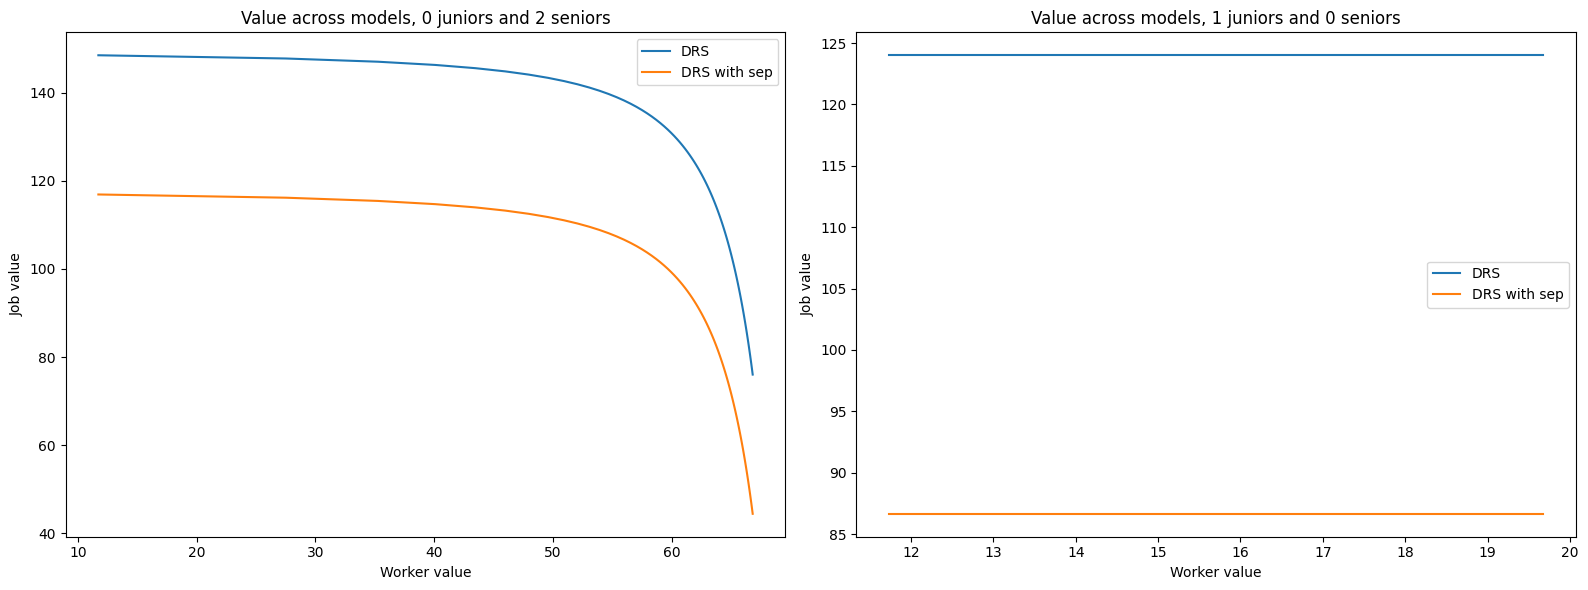

In [14]:
plts.ValueComparison(0,2,1,0,cc_W,cc_J,mwch_W,mwch_J,mwc_hmq_W[...,5,:],mwc_hmq_J[...,5],None,None,0)

In [ ]:
plts.ValueComparison(0,2,1,0,cc_W,cc_J,mwch_W,mwch_J,mwch_s_W,mwch_s_J,mwch_s_dir_W,mwch_s_dir_J,0)

In [ ]:
plts.ValueComparison(0,2,1,0,cc_W,cc_J,mwc_W,mwc_J,mwch_W,mwch_J,mwc_s_dir_W,mwc_s_dir_J,0)

In [ ]:
plts.sep(0,p.z_0-1,3,3,1,3,mwch_s_W,mwch_s_sep,mwch_s_dir_W,mwch_s_dir_sep)

In [ ]:
import matplotlib.pyplot as plt
import os
# Create a directory to save plots
output_dir = 'Plots'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [ ]:
jun=0
sen=0

if mwch_W is not None:        
    plt.plot(mwch_W[p.z_0-1, jun, sen, :, 1], mwch_n0[p.z_0-1, jun, sen, :], label='DRS')
if mwch_s_W is not None:        
    plt.plot(mwch_s_W[p.z_0-1, jun, sen, :, 1], mwch_s_n0[p.z_0-1, jun, sen, :], label='DRS with inv sep')
if mwch_s_dir_W is not None:        
    plt.plot(mwch_s_dir_W[p.z_0-1, jun, sen, :, 1], mwch_s_dir_n0[p.z_0-1, jun, sen, :], label='DRS with direct sep')

plt.title(f'Hires across models, {jun} juniors and {sen} seniors')
plt.xlabel('Worker value')
plt.ylabel('Hires')
plt.legend()
#Why does the job value rise when separations go to 1?
#Alex: when something strange is arising at the edge of the grid, it might be the extrapolation issue.
#Is there a way to check my intuition? Seems consistent with size and productivity changes

In [ ]:
plts.CRSvsDRSdirect(cc_J,mwc_J,0)

In [ ]:
plts.CRSvsDRSsurplus(cc_J,cc_W,mwc_J,mwc_W,0)

In [ ]:
import matplotlib.pyplot as plt
import os
# Create a directory to save plots
output_dir = 'Plots'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [ ]:
np.abs(mwc_s_sep[:,:1,:3,:]-mwc_s_dir_sep[:,:1,:3,:]).max()

In [ ]:
np.max(np.abs(mwc_s_sep[:,3,0,:]-mwc_s_dir_sep[:,3,0,:]))

In [ ]:
np.max(mwc_s_dir_sep[:,1,1,:])

In [ ]:
mwc_s_dir_sep[:,1,1,:]

In [ ]:
mwc_s_J[:,1,0,:]/mwc_s_J[:,3,0,:] #this is odd, should be 1/3 exactly, no? it is 1/3 in the case without separations, so why not here? there aren't even any separations!

In [ ]:
np.max(mwc_s_sep[:,3,0,:])

In [ ]:
mwc_s_sep[0,1,1,:] #if the two value functions intersect, then how come the separation rate is 1?
#also thats way too many separations